In [ ]:
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np


In [27]:
file = "data/output_with_sentiment.csv"
df = pd.read_csv(file)

In [28]:
df = df[["index",
    "text",
    "kontext",
    "klassifikation.tore_bayern",
    "klassifikation.tore_gegner",
    "klassifikation.phase",
    "meta.saison",
    "meta.spieltag",
    "meta.heim_auswaerts",
    "meta.gegner",
    "meta.tabelle",
    "meta.ballbesitz_bayern",
    "ergebnis.bayern",
    "ergebnis.gegner",
    "offizielle.schiedsrichter",
    "offizielle.kommentator",
    "source_file",
    "sentiment__fine_tuned_german_sentiment",
    "sentiment__fine_tuned_german_sentiment__conf"
]]

In [29]:
mapping = {'Positiv': 1, 'Negativ': -1, 'Neutral': 0}
df['sentiment_numeric'] = df['sentiment__fine_tuned_german_sentiment'].map(mapping)

In [30]:
df['weighted_sentiment'] = (
    df['sentiment_numeric'] * df['sentiment__fine_tuned_german_sentiment__conf']
)

In [ ]:

# Sicherstellen, dass nach Spiel und index sortiert ist
df = df.sort_values(['source_file', 'index']).copy()

# Phasen-Minutenbereiche definieren (anpassbar)
phase_bounds = {
    0: (-5, 0),    # Vor dem Spiel -> Minute 0
    1: (1, 45),   # 1. Halbzeit
    2: (46, 90),  # 2. Halbzeit
    3: (91, 95),  # Nach dem Spiel (zusammengefasst, ggf. anpassen)
}

# Position des Satzes innerhalb seiner Phase je Spiel (1..n)
df['__phase_pos'] = df.groupby(['source_file', 'klassifikation.phase']).cumcount() + 1
df['__phase_cnt'] = df.groupby(['source_file', 'klassifikation.phase'])['index'].transform('count')

# Fraktion innerhalb der Phase (0..1) – Mittelpunkt jeder "Bin"
df['__phase_frac'] = (df['__phase_pos'] - 0.5) / df['__phase_cnt']

# Interpolation: Fraktion auf Minutenbereich der Phase abbilden
def _interp_minute(phase, frac):
    lo, hi = phase_bounds.get(int(phase), (0, 0))
    if lo == hi:
        return float(lo)
    return float(lo + frac * (hi - lo))

df['schaetzung.spielminute'] = df.apply(
    lambda r: _interp_minute(r['klassifikation.phase'], r['__phase_frac']),
    axis=1
)

# Optional: auf ganze Minuten runden
df['schaetzung.spielminute'] = df['schaetzung.spielminute'].round(0).astype(int)

# Aufräumen von Hilfsspalten
df = df.drop(columns=['__phase_pos', '__phase_cnt', '__phase_frac'])
raw_df = df
df

,index,text,kontext,klassifikation.tore_bayern,klassifikation.tore_gegner,klassifikation.phase,meta.saison,meta.spieltag,meta.heim_auswaerts,meta.gegner,...,ergebnis.bayern,ergebnis.gegner,offizielle.schiedsrichter,offizielle.kommentator,source_file,sentiment__fine_tuned_german_sentiment,sentiment__fine_tuned_german_sentiment__conf,sentiment_numeric,weighted_sentiment,schaetzung.spielminute
0,0,Das erste Duell der Großkopferten seit dem Mei...,Neutral,0,0,0,23/24,10,Auswärts,Borussia Dortmund,...,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Neutral,0.8800,0,0.0000,-4
1,1,Ein Tor fehlte der Borussia zur Schale.,Borussia Dortmund,0,0,0,23/24,10,Auswärts,Borussia Dortmund,...,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Positiv,0.9411,1,0.9411,-3
2,2,Meister waren die Schwarzgelben für nur 8 Minu...,Borussia Dortmund,0,0,0,23/24,10,Auswärts,Borussia Dortmund,...,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Negativ,0.8543,-1,-0.8543,-2
3,3,Drei Tage nach Saarbrücken also Dortmund.,Borussia Dortmund,0,0,0,23/24,10,Auswärts,Borussia Dortmund,...,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Positiv,0.7713,1,0.7713,-1
4,4,Die Münchner starten die Mission Wiedergutmach...,FC Bayern München,0,0,1,23/24,10,Auswärts,Borussia Dortmund,...,4,0,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Negativ,0.8641,-1,-0.8641,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7402,95,"Wieder Sané, Guerreiro, viele Ballkontakte für...",FC Bayern München,3,0,2,24/25,9,Heim,1. FC Union Berlin,...,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Positiv,0.9257,1,0.9257,88
7403,96,"Sané hat noch mal die Chance, und Rönnow kann ...",Neutral,3,0,2,24/25,9,Heim,1. FC Union Berlin,...,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Neutral,0.9835,0,0.0000,89
7404,97,"Es ist die letzte Szene in einer Partie, die ü...",FC Bayern München,3,0,2,24/25,9,Heim,1. FC Union Berlin,...,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Positiv,0.9473,1,0.9473,90
7405,98,"Am Ende ein 3:0, das eigentlich nie in Frage s...",Neutral,3,0,3,24/25,9,Heim,1. FC Union Berlin,...,3,0,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Neutral,0.9743,0,0.0000,92


In [ ]:

# 1️⃣ Kontext dreistufig mappen
def map_kontext(x):
    x = str(x).strip()
    if x == 'FC Bayern München':
        return 'FC Bayern München'
    elif x.lower() == 'neutral':
        return 'Neutral'
    else:
        return 'Gegner'

df['kontext_group'] = df['kontext'].apply(map_kontext)

# 2️⃣ Minute berechnen (aus geschätzter Spielminute)
d = df.copy()
d = d[pd.notnull(d['schaetzung.spielminute'])]
d['minute'] = d['schaetzung.spielminute'].round().astype(int).clip(lower=-5, upper=95)

# 4️⃣ Durchschnitt je Minute & Kontext (inkl. Neutral)
sentiment_per_minute = (
    d.groupby(['minute', 'kontext_group'], as_index=False)['weighted_sentiment']
      .mean()
      .pivot(index='minute', columns='kontext_group', values='weighted_sentiment')
      .rename(columns={
          'FC Bayern München': 'sentiment.bayern',
          'Gegner': 'sentiment.gegner',
          'Neutral': 'sentiment.neutral'
      })
      .reindex(range(-5, 96))  # alle Minuten 0–95
)

# 5️⃣ Glätten (optional, 5-Minuten-Fenster)
sentiment_per_minute_smooth = sentiment_per_minute.rolling(window=5, min_periods=1, center=True).mean()
sentiment_per_minute


kontext_group,sentiment.bayern,sentiment.gegner,sentiment.neutral
minute,,,
-5,0.935300,0.952500,0.000000
-4,0.699165,0.886467,-0.157726
-3,0.580940,0.923225,-0.182962
-2,0.528779,0.504569,-0.019207
-1,0.413500,0.570225,0.039124
...,...,...,...
91,0.746688,0.341633,-0.063845
92,0.678116,0.809990,-0.141877
93,0.702230,0.640686,-0.033830


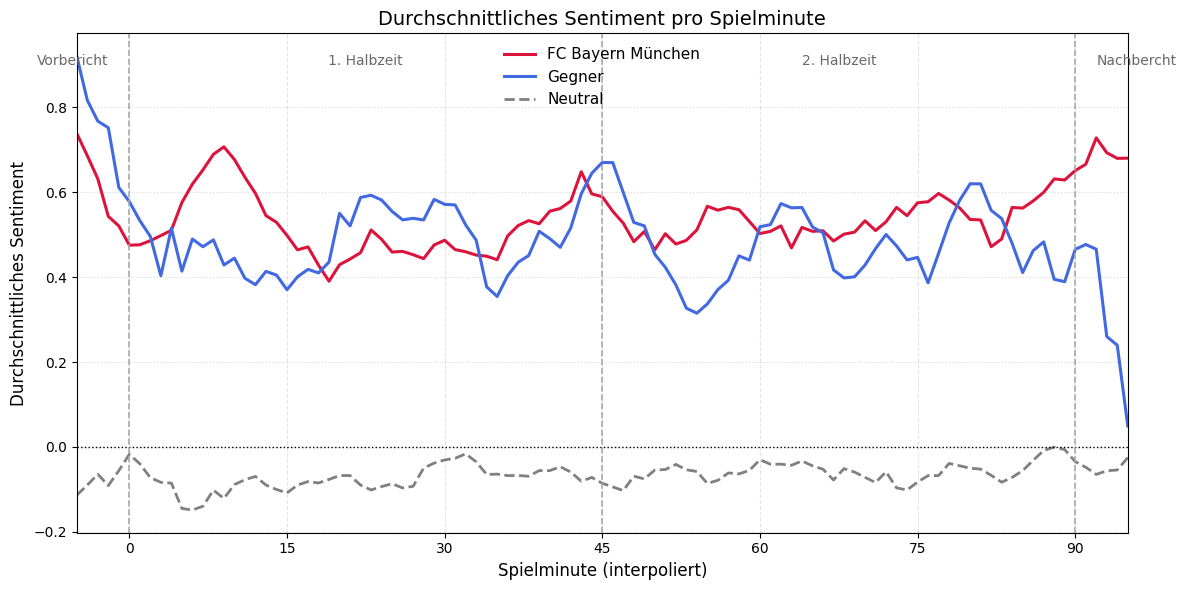

In [ ]:


plt.figure(figsize=(12, 6))

# 🔴 FC Bayern München
plt.plot(
    sentiment_per_minute_smooth.index,
    sentiment_per_minute_smooth['sentiment.bayern'],
    label='FC Bayern München',
    color='crimson',
    linewidth=2.2
)

# 🔵 Gegner
plt.plot(
    sentiment_per_minute_smooth.index,
    sentiment_per_minute_smooth['sentiment.gegner'],
    label='Gegner',
    color='royalblue',
    linewidth=2.2
)

# ⚫ Neutral
if 'sentiment.neutral' in sentiment_per_minute_smooth.columns:
    plt.plot(
        sentiment_per_minute_smooth.index,
        sentiment_per_minute_smooth['sentiment.neutral'],
        label='Neutral',
        color='gray',
        linestyle='--',
        linewidth=2
    )

# ⚫ Horizontale Null-Linie
plt.axhline(0, color='black', linestyle=':', linewidth=1)

# 🟩 Vertikale Linien für Spielphasen
for x in [0, 45, 90]:
    plt.axvline(x, color='darkgray', linestyle='--', linewidth=1.2)

# 🏷️ Phase-Beschriftungen
ylim = plt.ylim()
plt.text(-2,   ylim[1]*0.95, 'Vorbericht', ha='right', va='top', fontsize=10, color='dimgray')
plt.text(22.5, ylim[1]*0.95, '1. Halbzeit', ha='center', va='top', fontsize=10, color='dimgray')
plt.text(67.5, ylim[1]*0.95, '2. Halbzeit', ha='center', va='top', fontsize=10, color='dimgray')
plt.text(92,   ylim[1]*0.95, 'Nachbercht', ha='left', va='top', fontsize=10, color='dimgray')

# 🧭 Achsen, Raster & Layout
plt.xlabel('Spielminute (interpoliert)', fontsize=12)
plt.ylabel('Durchschnittliches Sentiment', fontsize=12)
plt.title('Durchschnittliches Sentiment pro Spielminute', fontsize=14)
plt.xlim(-5, 95)

# 🧮 Grid in 15-Minuten-Schritten
plt.xticks(np.arange(0, 100, 15))
plt.grid(which='both', axis='x', linestyle='--', color='lightgray', alpha=0.6)
plt.grid(which='major', axis='y', linestyle=':', color='gray', alpha=0.3)

# 🎨 Legende & Style
plt.legend(frameon=False, fontsize=11, loc='upper center')
plt.tight_layout()

file_prefix = "data/results"
filename = "spielverlauf_interpoliert"
plt.savefig(f'{file_prefix}/grafiken_png/{filename}.png')
plt.savefig(f'{file_prefix}/grafiken_pdf/{filename}.pdf')

plt.show()

In [34]:
subset = (
    raw_df.loc[
        (raw_df["klassifikation.tore_bayern"] == 1) &
        (raw_df["klassifikation.tore_gegner"] == 0)
    ]
    .sort_values("index")
    .drop_duplicates("source_file")
)

stats = subset['schaetzung.spielminute'].agg(['mean', 'std'])
stats

mean    21.840000
std     20.779071
Name: schaetzung.spielminute, dtype: float64

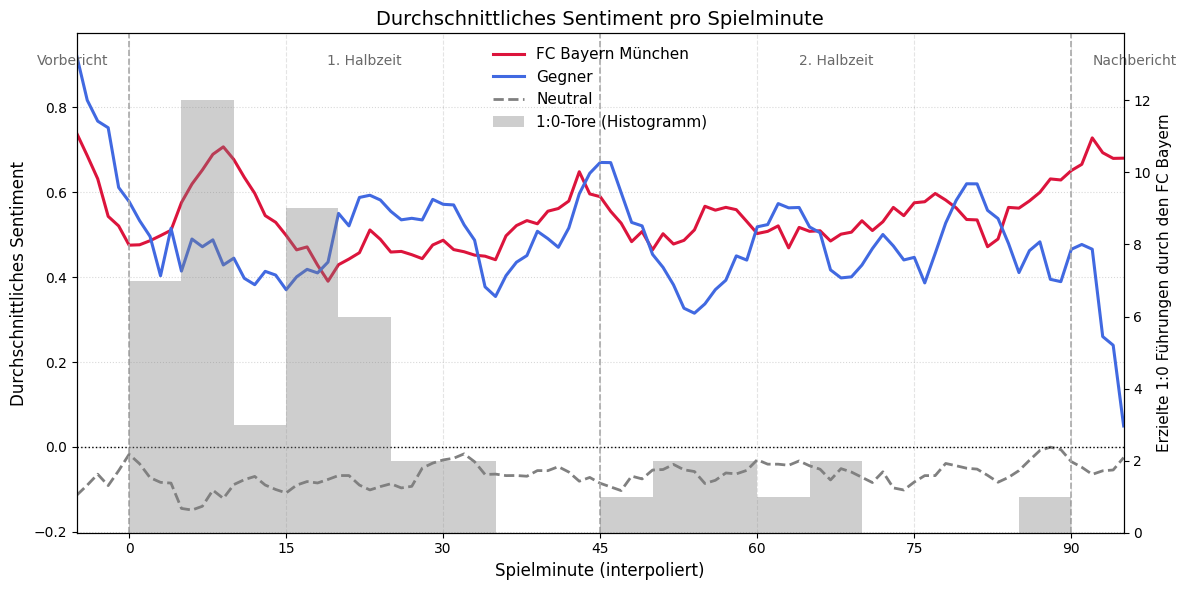

In [ ]:

# 🔢 Datenbasis für das Histogramm (1:0-Tore Bayern, erste pro Spiel)
subset = (
    raw_df.loc[
        (raw_df["klassifikation.tore_bayern"] == 1) &
        (raw_df["klassifikation.tore_gegner"] == 0)
    ]
    .sort_values("index")
    .drop_duplicates("source_file")
)

fig, ax1 = plt.subplots(figsize=(12, 6))

# 📊 Histogramm im Hintergrund auf zweiter Y-Achse
ax2 = ax1.twinx()
ax2.hist(
    subset['schaetzung.spielminute'],
    bins=20,
    range=(-5, 95),
    alpha=0.38,
    color='gray',
    edgecolor=None
)
ax2.set_ylabel("Erzielte 1:0 Führungen durch den FC Bayern", fontsize=11, color="black")
ax2.set_ylim(0, ax2.get_ylim()[1] * 1.1)
ax2.tick_params(axis='y', labelcolor='black')

# 🔴 FC Bayern München
ax1.plot(
    sentiment_per_minute_smooth.index,
    sentiment_per_minute_smooth['sentiment.bayern'],
    label='FC Bayern München',
    color='crimson',
    linewidth=2.2
)

# 🔵 Gegner
ax1.plot(
    sentiment_per_minute_smooth.index,
    sentiment_per_minute_smooth['sentiment.gegner'],
    label='Gegner',
    color='royalblue',
    linewidth=2.2
)

# ⚫ Neutral
if 'sentiment.neutral' in sentiment_per_minute_smooth.columns:
    ax1.plot(
        sentiment_per_minute_smooth.index,
        sentiment_per_minute_smooth['sentiment.neutral'],
        label='Neutral',
        color='gray',
        linestyle='--',
        linewidth=2
    )

# 🔗 Legenden-Handles einsammeln und Histogramm ergänzen
leg_handles, leg_labels = ax1.get_legend_handles_labels()
hist_patch = Patch(facecolor='gray', alpha=0.38, label='1:0-Tore (Histogramm)')
leg_handles.append(hist_patch)
leg_labels.append('1:0-Tore (Histogramm)')

# ⚫ Horizontale Null-Linie
ax1.axhline(0, color='black', linestyle=':', linewidth=1)

# 🟩 Vertikale Linien
for x in [0, 45, 90]:
    ax1.axvline(x, color='darkgray', linestyle='--', linewidth=1.2)

# 🏷️ Phase-Beschriftungen
ylim = ax1.get_ylim()
ax1.text(-2,   ylim[1]*0.95, 'Vorbericht',  ha='right',  va='top', fontsize=10, color='dimgray')
ax1.text(22.5, ylim[1]*0.95, '1. Halbzeit', ha='center', va='top', fontsize=10, color='dimgray')
ax1.text(67.5, ylim[1]*0.95, '2. Halbzeit', ha='center', va='top', fontsize=10, color='dimgray')
ax1.text(92,   ylim[1]*0.95, 'Nachbericht', ha='left',   va='top', fontsize=10, color='dimgray')

# 🧭 Achsen, Raster & Layout
ax1.set_xlabel('Spielminute (interpoliert)', fontsize=12)
ax1.set_ylabel('Durchschnittliches Sentiment', fontsize=12)
ax1.set_title('Durchschnittliches Sentiment pro Spielminute', fontsize=14)
ax1.set_xlim(-5, 95)

ax1.set_xticks(np.arange(0, 100, 15))
ax1.grid(which='both', axis='x', linestyle='--', color='lightgray', alpha=0.6)
ax1.grid(which='major', axis='y', linestyle=':', color='gray', alpha=0.3)

# 🧾 Legende inkl. Histogramm
ax1.legend(
    leg_handles,
    leg_labels,
    frameon=False,
    fontsize=11,
    loc='upper center'
)

plt.tight_layout()

file_prefix = "data/results"
filename = "spielverlauf_mit_erstem_tor"
plt.savefig(f'{file_prefix}/grafiken_png/{filename}.png')
plt.savefig(f'{file_prefix}/grafiken_pdf/{filename}.pdf')

plt.show()

In [36]:
raw_df['bayern_tor_event'] = (
    raw_df
    .groupby('source_file')['klassifikation.tore_bayern']
    .diff() == 1
)

raw_df.loc[raw_df["bayern_tor_event"] == True]

,index,text,kontext,klassifikation.tore_bayern,klassifikation.tore_gegner,klassifikation.phase,meta.saison,meta.spieltag,meta.heim_auswaerts,meta.gegner,...,offizielle.schiedsrichter,offizielle.kommentator,source_file,sentiment__fine_tuned_german_sentiment,sentiment__fine_tuned_german_sentiment__conf,sentiment_numeric,weighted_sentiment,schaetzung.spielminute,kontext_group,bayern_tor_event
7,7,Vor der Südtribüne Sané und in der Mitte vogel...,FC Bayern München,1,0,1,23/24,10,Auswärts,Borussia Dortmund,...,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Positiv,0.8224,1,0.8224,3,FC Bayern München,True
27,27,"Neunte Minute, so früh schon das 2:0 für den i...",FC Bayern München,2,0,1,23/24,10,Auswärts,Borussia Dortmund,...,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Positiv,0.9092,1,0.9092,12,FC Bayern München,True
141,141,"Harry Kane legt auf für Musiala, 3:0.",FC Bayern München,3,0,2,23/24,10,Auswärts,Borussia Dortmund,...,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Positiv,0.9467,1,0.9467,76,FC Bayern München,True
162,162,"Süle, Pavlovic, Harry Kane zum dritten, 4:0, 9...",FC Bayern München,4,0,2,23/24,10,Auswärts,Borussia Dortmund,...,Deniz Aytekin,Oliver Schmidt,23-24_S10_borussia_dortmund.json,Positiv,0.9578,1,0.9578,90,FC Bayern München,True
190,11,"14. Minute, 1:0 Bayern München.",FC Bayern München,1,0,1,23/24,11,Heim,1. FC Heidenheim,...,Harm Osmers,Martin Gräfe,23-24_S11_1._fc_heidenheim.json,Positiv,0.9586,1,0.9586,8,FC Bayern München,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278,71,"Medic in die Füße von Sané, Leroy Sané, 65. Mi...",FC Bayern München,4,0,2,24/25,8,Auswärts,VfL Bochum,...,Florian Exner,Martin Gräfe,24-25_S8_vfl_bochum.json,Neutral,0.7129,0,0.0000,68,FC Bayern München,True
7285,78,"Coman, Rums, 71. Minute, 5:0.",FC Bayern München,5,0,2,24/25,8,Auswärts,VfL Bochum,...,Florian Exner,Martin Gräfe,24-25_S8_vfl_bochum.json,Positiv,0.9536,1,0.9536,74,FC Bayern München,True
7328,21,22 Elfmeter in Folge hat Kane verwandelt.,FC Bayern München,1,0,1,24/25,9,Heim,1. FC Union Berlin,...,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Positiv,0.9460,1,0.9460,17,FC Bayern München,True
7351,44,"Die Bayern machen alles richtig, und die Bayer...",FC Bayern München,2,0,1,24/25,9,Heim,1. FC Union Berlin,...,Dr. Matthias Jöllenbeck,Hansi Küpper,24-25_S9_1._fc_union_berlin.json,Positiv,0.9612,1,0.9612,37,FC Bayern München,True


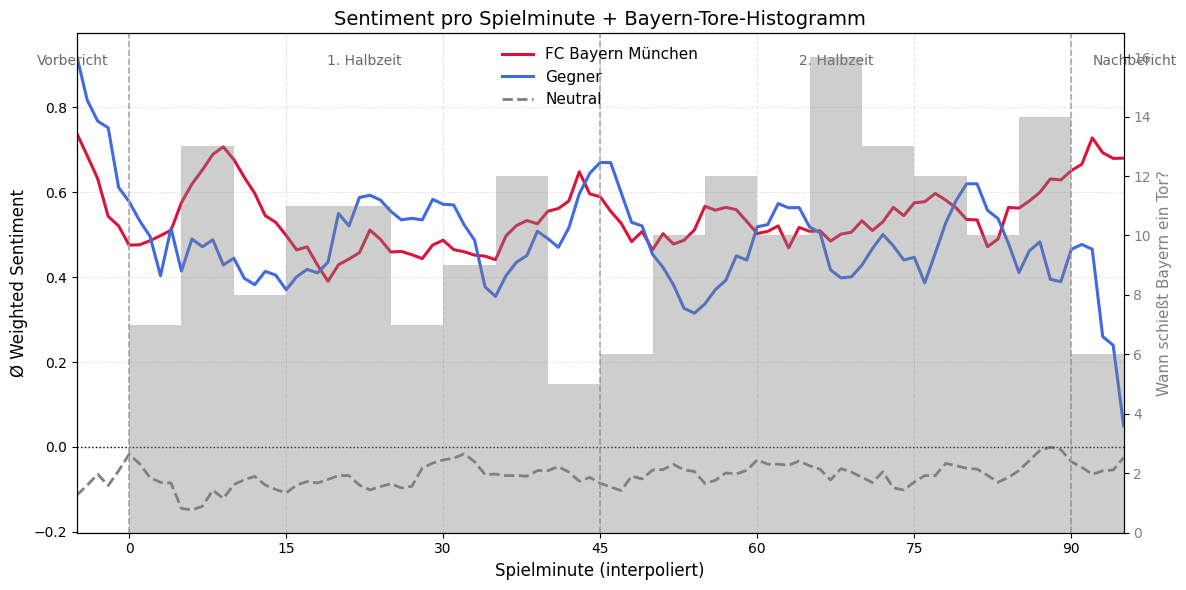

In [ ]:

# ---------------------------------------------------------
# 1) Bayern-Tor-Events berechnen (jedes +1 gegenüber vorher)
# ---------------------------------------------------------
raw_df = raw_df.sort_values(["source_file", "index"])

raw_df['bayern_tor_event'] = (
    raw_df
    .groupby('source_file')['klassifikation.tore_bayern']
    .diff() == 1
)

# Alle Tor-Minuten extrahieren
bayern_tor_minuten = raw_df.loc[
    raw_df['bayern_tor_event'], 
    'schaetzung.spielminute'
]

# ---------------------------------------------------------
# 2) Plot mit Histogramm auf zusätzlicher Y-Achse
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Zweite Y-Achse für Histogramm
ax2 = ax1.twinx()
ax2.hist(
    bayern_tor_minuten,
    bins=20,
    range=(-5, 95),
    alpha=0.38,
    color='gray'
)
ax2.set_ylabel("Wann schießt Bayern ein Tor?", fontsize=11, color="gray")
ax2.tick_params(axis='y', labelcolor='gray')

# ---------------------------------------------------------
# 3) Sentiment-Kurven wie vorher
# ---------------------------------------------------------

# FC Bayern
ax1.plot(
    sentiment_per_minute_smooth.index,
    sentiment_per_minute_smooth['sentiment.bayern'],
    label='FC Bayern München',
    color='crimson',
    linewidth=2.2
)

# Gegner
ax1.plot(
    sentiment_per_minute_smooth.index,
    sentiment_per_minute_smooth['sentiment.gegner'],
    label='Gegner',
    color='royalblue',
    linewidth=2.2
)

# Neutral
if 'sentiment.neutral' in sentiment_per_minute_smooth.columns:
    ax1.plot(
        sentiment_per_minute_smooth.index,
        sentiment_per_minute_smooth['sentiment.neutral'],
        label='Neutral',
        color='gray',
        linestyle='--',
        linewidth=2
    )

# Null-Linie
ax1.axhline(0, color='black', linestyle=':', linewidth=1)

# Halbzeitmarken
for x in [0, 45, 90]:
    ax1.axvline(x, color='darkgray', linestyle='--', linewidth=1.2)

# Phase-Text
ylim = ax1.get_ylim()
ax1.text(-2,   ylim[1]*0.95, 'Vorbericht',  ha='right',  va='top', fontsize=10, color='dimgray')
ax1.text(22.5, ylim[1]*0.95, '1. Halbzeit', ha='center', va='top', fontsize=10, color='dimgray')
ax1.text(67.5, ylim[1]*0.95, '2. Halbzeit', ha='center', va='top', fontsize=10, color='dimgray')
ax1.text(92,   ylim[1]*0.95, 'Nachbericht', ha='left',   va='top', fontsize=10, color='dimgray')

# Achsen & Layout
ax1.set_xlabel('Spielminute (interpoliert)', fontsize=12)
ax1.set_ylabel('Ø Weighted Sentiment', fontsize=12)
ax1.set_title('Sentiment pro Spielminute + Bayern-Tore-Histogramm', fontsize=14)
ax1.set_xlim(-5, 95)

ax1.set_xticks(np.arange(0, 100, 15))
ax1.grid(which='both', axis='x', linestyle='--', color='lightgray', alpha=0.6)
ax1.grid(which='major', axis='y', linestyle=':', color='gray', alpha=0.3)

ax1.legend(frameon=False, fontsize=11, loc='upper center')
plt.tight_layout()
plt.show()